In [1]:
from pathlib import Path

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interpolate

import project_path
import nn.utils as utils
import nn.model.net as net
import nn.model.data as data
import nn.model.loss as loss

## Constants

In [2]:
NUM_CLASSES = 5
CLASSES = ['Gluon', 'Lght quarks', 'W boson', 'Z boson', 'Top quark']
MODEL_DIR = Path("../../experiments/constituent_cluster/best.script.pth")

In [3]:
torch.manual_seed(230)

## Data

In [4]:
# (1) creating dataset
datasets = data.get_dataset(splits=['train-val', 'test'])
dataset = datasets['train-val']
test_set = datasets['test']

# (2) train-validation split
dataset_size = len(dataset)
train_set, val_set, _ = torch.utils.data.random_split(dataset, [dataset_size - 1000, 1000, 0])

# (3) train-validation dataloaders
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=data.get_collate_fn())
val_loader = data.DataLoader(val_set, batch_size=32, collate_fn=data.get_collate_fn())
test_loader = data.DataLoader(test_set, batch_size=32, collate_fn=data.get_collate_fn())

In [5]:
# model = net.ConstituentNetPerceiver(num_perceivers=1, num_latent_transformers=1, embbed_dim=16, num_embbeds=16)
# print(f'Number of parameters: {utils.count_parameters(model)}')

## Model

In [6]:
model = torch.jit.load(MODEL_DIR, map_location='cpu')
print(f'Number of parameters: {utils.count_parameters(model)}')
model.eval()

Number of parameters: 691205


RecursiveScriptModule(
  original_name=ConstituentNetV2
  (inp_layer): RecursiveScriptModule(original_name=Linear)
  (encoder_blocks): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Transformer
      (self_attention): RecursiveScriptModule(
        original_name=SelfAttention
        (norm): RecursiveScriptModule(original_name=LayerNorm)
        (qkv): RecursiveScriptModule(original_name=Linear)
        (out): RecursiveScriptModule(original_name=Linear)
      )
      (linear): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=LayerNorm)
        (1): RecursiveScriptModule(original_name=SiLU)
        (2): RecursiveScriptModule(original_name=Linear)
        (3): RecursiveScriptModule(original_name=LayerNorm)
        (4): RecursiveScriptModule(original_name=SiLU)
        (5): RecursiveScriptModule(original_name=Linear)
      )
      (dropout): RecursiveScriptModule(original_name=

## Evaluation

In [12]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(val_loader), unit="batch") as t:
    for i, batch in enumerate(val_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs, energy = model(input_seqs)                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:20<00:00,  2.51s/batch]


### Confusion Matrix

Accuracy:  0.834


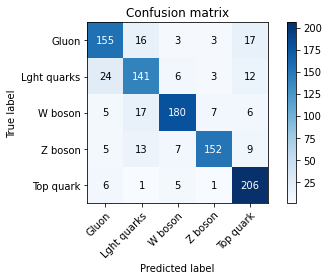

In [13]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [14]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

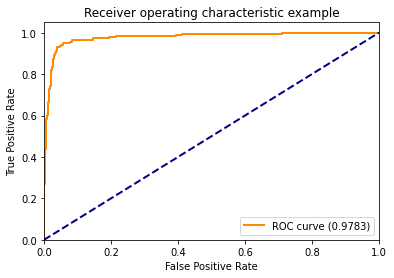

In [15]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.8865979381443299
 Lght quarks: 0.8655913978494624
 W boson:     0.9209302325581395
 Z boson:     0.9193548387096774
 Top quark:   0.9634703196347032

TPR for FPR = 1%
 Gluon:       0.5515463917525774
 Lght quarks: 0.3064516129032258
 W boson:     0.6093023255813953
 Z boson:     0.7903225806451613
 Top quark:   0.6027397260273972


## Test

In [7]:
# Loss
criterion = torch.nn.NLLLoss()

# Statistics summary
loss_avg = utils.RunningAverage()
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(test_loader), unit="batch") as t:
    for i, batch in enumerate(test_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs, energy = model(input_seqs)                 # torch.tensor (n, num_classes)
        
        # Calculate Loss
        loss = criterion(outputs, targets)
        loss_avg.update(loss.item())

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 313/313 [02:37<00:00,  1.99batch/s]


### Confusion Matrix

Accuracy:  0.8262
Loss:  0.504011476144623


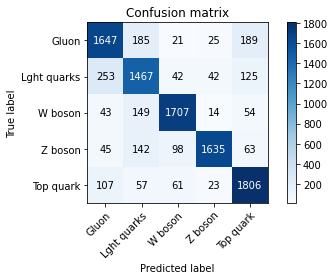

In [8]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, Loss,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))
print("Loss: ", loss_avg())

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [9]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

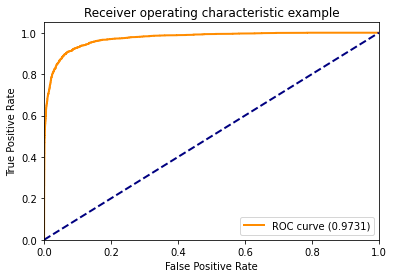

In [10]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [11]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.872278664731495
 Lght quarks: 0.8252980819077242
 W boson:     0.9440772750381291
 Z boson:     0.9198184568835098
 Top quark:   0.928919182083739

TPR for FPR = 1%
 Gluon:       0.5041122399612966
 Lght quarks: 0.31207879730430277
 W boson:     0.7564819522114896
 Z boson:     0.8083711548159355
 Top quark:   0.681110029211295


In [12]:
print(roc_aucs)

{0: 0.9579221505019877, 1: 0.9407167813853191, 2: 0.9804444186794041, 3: 0.9746837139006994, 4: 0.973084784074391, 'micro': 0.96726619625}
